In [1]:
import numpy as np 
import pandas as pd

import utils
import torch 
import os
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
from textwrap import wrap
import seaborn as sns
from albumentations.pytorch import ToTensorV2

/home/f/ProjectII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Data preprocessing

In [2]:
# For Kaggle
#root_dir = '/kaggle/input/'
#train = pd.read_csv('/kaggle/input/chexpert/train.csv', index_col=0)
#valid = pd.read_csv('/kaggle/input/chexpert/valid.csv', index_col=0)

root_dir = ''
train = pd.read_csv('train.csv', index_col=0)
valid = pd.read_csv('valid.csv', index_col=0)

In [3]:
valid

,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
Path,,,,,,,,,,,,,,,,,,
CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CheXpert-v1.0-small/valid/patient64736/study1/view1_frontal.jpg,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CheXpert-v1.0-small/valid/patient64737/study1/view1_frontal.jpg,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CheXpert-v1.0-small/valid/patient64738/study1/view1_frontal.jpg,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Since valid data is too small (234 images), we combine train and valid and then resplit it into train, valid, and test (80/10/10)

In [4]:
data = pd.concat([train, valid])

In [5]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 223648 entries, CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg to CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg
Columns: 18 entries, Sex to Support Devices
dtypes: float64(14), int64(1), object(3)
memory usage: 32.4+ MB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,223648.0,60.431030,17.821668,0.0,49.0,62.0,74.0,90.0
No Finding,22615.0,0.991333,0.092693,0.0,1.0,1.0,1.0,1.0
Enlarged Cardiomediastinum,45073.0,-0.033191,0.718381,-1.0,-1.0,0.0,0.0,1.0
Cardiomegaly,46437.0,0.408747,0.768105,-1.0,0.0,1.0,1.0,1.0
Lung Opacity,118012.0,0.848295,0.472826,-1.0,1.0,1.0,1.0,1.0
Lung Lesion,12178.0,0.632206,0.690605,-1.0,1.0,1.0,1.0,1.0
Edema,86190.0,0.456051,0.741190,-1.0,0.0,1.0,1.0,1.0
Consolidation,70856.0,-0.182426,0.753230,-1.0,-1.0,0.0,0.0,1.0
Pneumonia,27842.0,-0.456971,0.826168,-1.0,-1.0,-1.0,0.0,1.0
Atelectasis,68677.0,-0.004121,0.989150,-1.0,-1.0,0.0,1.0,1.0


In [7]:
print(data['Sex'].value_counts())
print(data['Age'].value_counts())
print(data['Frontal/Lateral'].value_counts())
print(data['AP/PA'].value_counts())

Sex
Male       132764
Female      90883
Unknown         1
Name: count, dtype: int64
Age
90    7590
61    5375
65    5103
66    5102
58    5080
      ... 
21    1281
23    1234
19    1169
18     768
0        3
Name: count, Length: 74, dtype: int64
Frontal/Lateral
Frontal    191229
Lateral     32419
Name: count, dtype: int64
AP/PA
AP    161759
PA     29453
LL        16
RL         1
Name: count, dtype: int64


Remove lateral view

In [8]:
data = data[data['Frontal/Lateral'] == 'Frontal']

Drop unused columns

In [9]:
data.drop(columns=['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], inplace=True)

NaN values represent no conclusion so set it to negative (0)

In [10]:
data.fillna(0, inplace=True)

Treat uncertain labels (-1) as either positive (1) or negative (0)

In [11]:
data.replace(-1, 0, inplace=True)

Set rows with no labels the label 'No Finding' to 1 (positive)

In [12]:
rows_with_no_labels = (data == 0).all(axis=1)
data.loc[rows_with_no_labels, 'No Finding'] = 1

(data == 0).all(axis=1).any()

np.False_

Show demo images

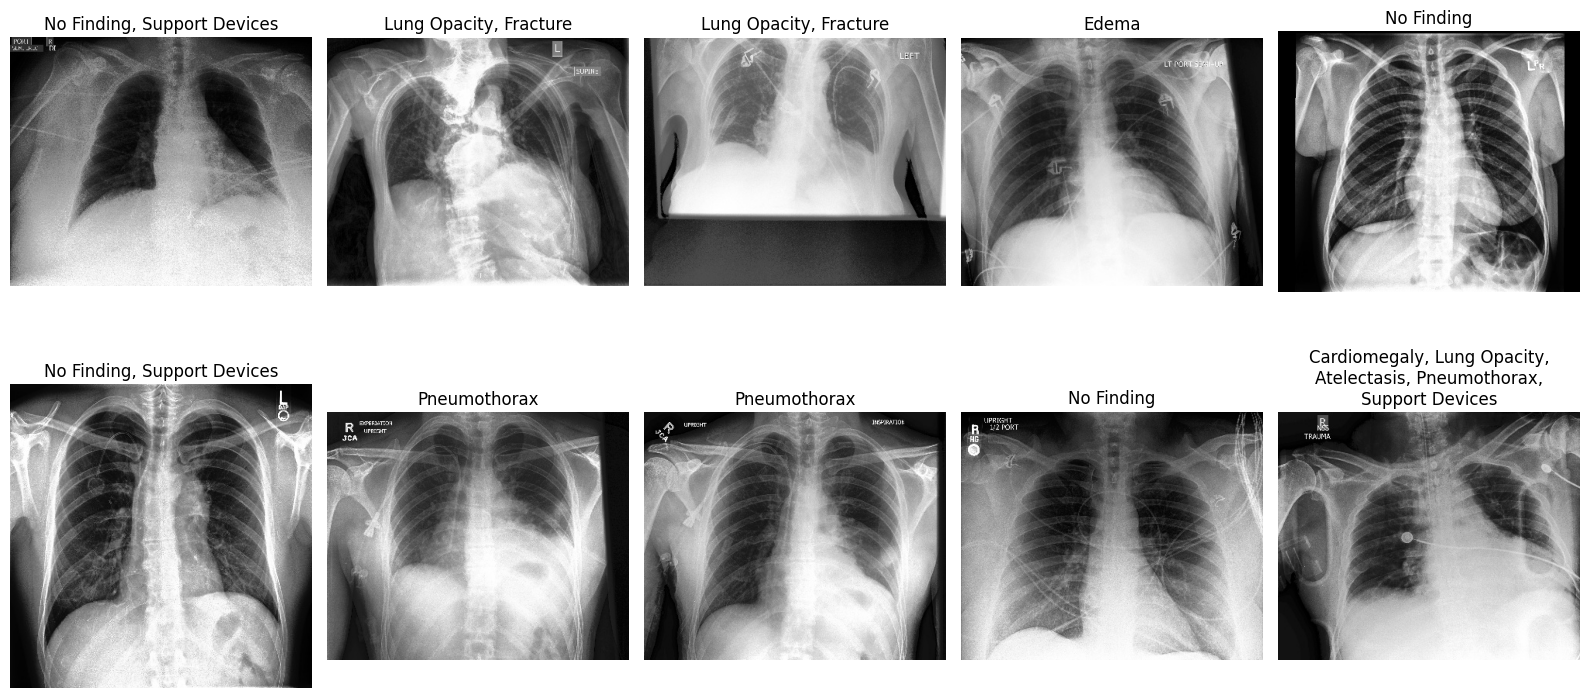

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for i, ax in zip(range(10), axes):
    img_path = os.path.join(root_dir, data.iloc[i].name)
    img = Image.open(img_path).convert('RGB')
    
    conditions = data.columns[np.where(data.iloc[i] == 1)]

    ax.imshow(img)
    ax.set_title("\n".join(wrap(", ".join(conditions), 30)))
    ax.axis("off")

plt.tight_layout()
plt.show()


Correlation Heatmap

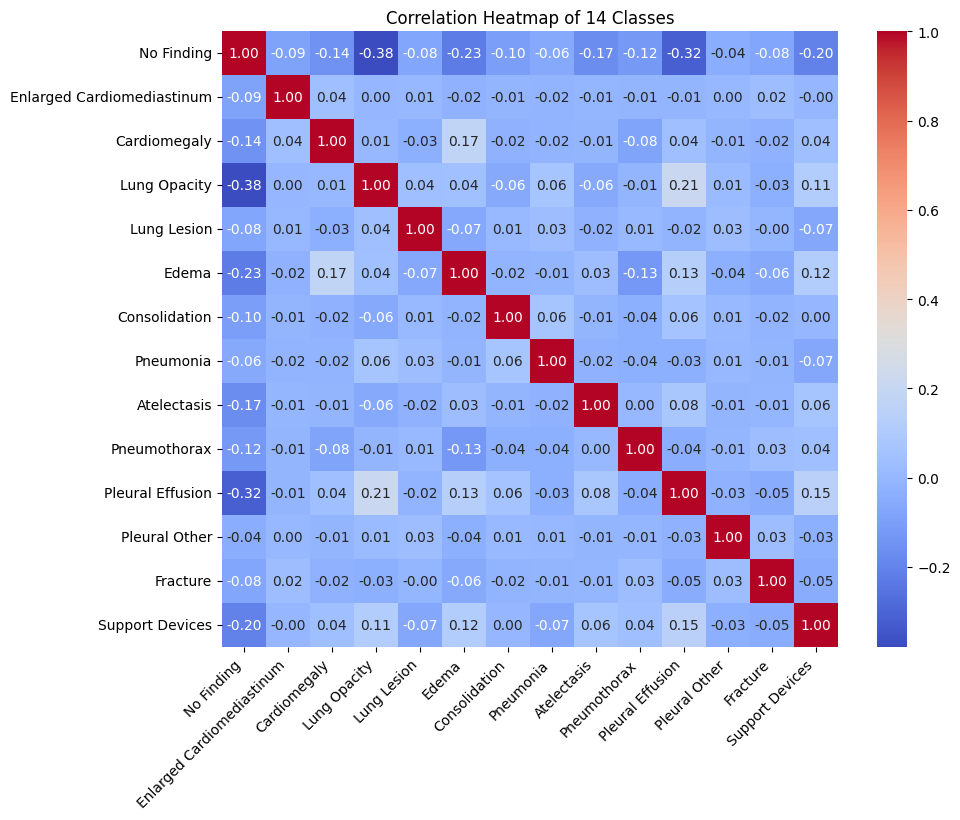

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title("Correlation Heatmap of 14 Classes")
plt.xticks(rotation=45, ha='right')
plt.show()

Class distribution

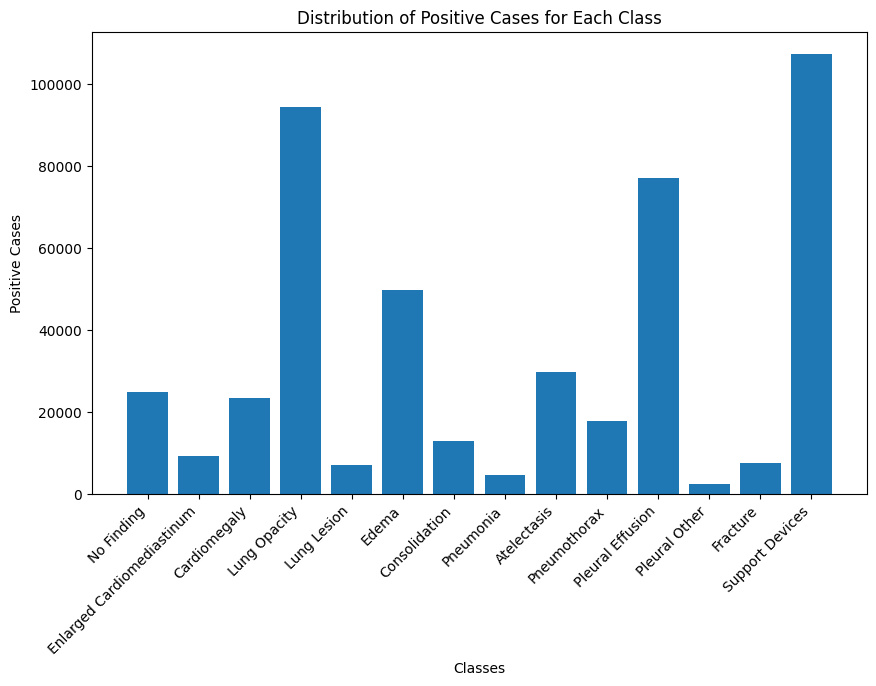

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(data.sum().index, data.sum().values)
plt.title("Distribution of Positive Cases for Each Class")
plt.xlabel("Classes")
plt.ylabel("Positive Cases")
plt.xticks(rotation=45, ha='right')
plt.show()

Co-occurence of classes

In [16]:
data.T.dot(data).astype(int)

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
No Finding,24771,0,0,0,0,0,0,0,0,0,0,0,0,7421
Enlarged Cardiomediastinum,0,9292,1648,4595,381,2053,534,128,1357,703,3495,138,559,5152
Cardiomegaly,0,1648,23451,11734,461,10826,1269,394,3423,706,10530,226,636,14247
Lung Opacity,0,4595,11734,94328,4125,26332,4929,3225,12700,8434,47822,1382,3105,58251
Lung Lesion,0,381,461,4125,7041,775,592,314,837,773,2541,212,247,2734
Edema,0,2053,10826,26332,775,49717,3047,1089,8590,1434,25280,268,933,32686
Consolidation,0,534,1269,4929,592,3047,13015,796,1816,685,6662,223,338,7354
Pneumonia,0,128,394,3225,314,1089,796,4683,507,126,1403,85,109,1586
Atelectasis,0,1357,3423,12700,837,8590,1816,507,29795,2852,14636,284,1079,18939
Pneumothorax,0,703,706,8434,773,1434,685,126,2852,17700,5967,200,968,10961


Singular condition

In [17]:
data[data.sum(1)==1].sum(0)

No Finding                    17350.0
Enlarged Cardiomediastinum     1028.0
Cardiomegaly                   1539.0
Lung Opacity                   8449.0
Lung Lesion                     782.0
Edema                          3080.0
Consolidation                  1034.0
Pneumonia                       423.0
Atelectasis                    1716.0
Pneumothorax                   2274.0
Pleural Effusion               3572.0
Pleural Other                   291.0
Fracture                       1377.0
Support Devices                5303.0
dtype: float64

Multi-label stratified sampling

In [18]:
X, y = data.index.to_numpy().reshape(-1, 1), data.values
# X is image paths array, y is multi label array

In [19]:
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size = 0.2)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

Save the newly split Train/Validation/Test

In [20]:
pd.DataFrame(data=y_train, columns=data.columns, index=X_train.flatten()).to_csv('u0_train.csv')
pd.DataFrame(data=y_test, columns=data.columns, index=X_test.flatten()).to_csv('u0_test.csv')
pd.DataFrame(data=y_val, columns=data.columns, index=X_val.flatten()).to_csv('u0_val.csv')

In [21]:
#train = pd.read_csv('/kaggle/working/u1_train.csv', index_col=0)
train = pd.read_csv('u0_train.csv', index_col=0)

Find the mean and standard deviation of training dataset for normalization

In [22]:
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm  # Use notebook-compatible tqdm

class CheXpertDataset(Dataset):
    def __init__(self, data, root_dir, mode='train', transforms=None):
        # Store data as numpy for compatibility
        self.data = data.values.astype(np.float32)
        self.root_dir = root_dir
        self.img_paths = [os.path.join(root_dir, img_path) for img_path in data.index]
        
        # Prepare transforms
        self.transform = transforms.get(mode) if transforms else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        from PIL import Image
        
        # Load image
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Convert label to tensor
        label = torch.tensor(self.data[idx], dtype=torch.float32)
        
        return (image, label)

def calculate_mean_std(train_data, root_dir):
    # Prepare transforms for dataset
    transforms_dict = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    }
    
    # Determine device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataset
    dataset = CheXpertDataset(
        data=train_data,
        root_dir=root_dir,
        mode='train',
        transforms=transforms_dict
    )
    
    # Create DataLoader with num_workers=0 for notebooks
    loader = DataLoader(
        dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0,  # Important for notebooks
        pin_memory=torch.cuda.is_available()
    )
    
    # Ensure calculations are done on the same device
    pixel_sum = torch.tensor(0.0, device=device)
    pixel_squared_sum = torch.tensor(0.0, device=device)
    n_pixels = 0
    
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(loader, desc="Processing batches"):
            image_batch, _ = batch
            # Move batch to device
            image_batch = image_batch.to(device)
            
            batch_size, channels, height, width = image_batch.size()
            
            # Convert to grayscale by taking mean across channels
            image_batch_gray = image_batch.mean(dim=1, keepdim=True)
            
            n_pixels += batch_size * height * width
            pixel_sum += image_batch_gray.sum()
            pixel_squared_sum += (image_batch_gray ** 2).sum()
    
    # Transfer results back to CPU for final calculations
    mean = pixel_sum.item() / n_pixels
    variance = (pixel_squared_sum.item() / n_pixels) - (mean ** 2)
    std = np.sqrt(variance)
    
    return mean, std

# Usage in notebook
# Assume train and root_dir are already defined
try:
    mean, std = calculate_mean_std(train, root_dir)
    print(f"Mean: {mean}, Std: {std}")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Using device: cuda


Processing batches:   0%|          | 0/9588 [00:00<?, ?it/s]

Mean: 0.5063839699786984, Std: 0.2867094887587066


Plot augmentation methods

In [23]:
augs = {'default': None, 'rotate':A.Affine(rotate=(-20, 20), p=1), 'scale': A.Affine(scale=(0.9, 1.1), p=1), 'shear': A.Affine(shear=(-5, 5), p=1), 'translation': A.Affine(translate_percent=(-0.05, 0.05), p=1)}

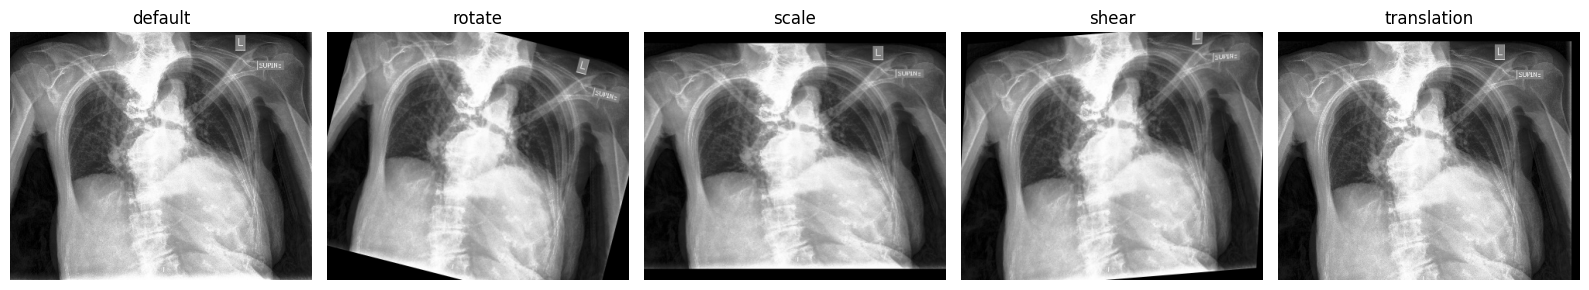

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(16, 8))
axes = axes.flatten()
img_path = os.path.join(root_dir, train.iloc[1].name)
img = Image.open(img_path).convert('RGB')

for aug, ax in zip(augs.keys(), axes):
    if aug == 'default':
        ax.imshow(img)
    else:
        aug_img = augs[aug](image=np.array(img))
        ax.imshow(aug_img['image'])
    ax.set_title(f"{aug}")
    ax.axis("off")

plt.tight_layout()
plt.show()